In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

In [3]:
MODEL = 'bart'

RE_SPLITTER = '\n'              # do we split sentences of paragraphs?
                                # use '\.(?!\d)|\n' or '\n', respectively

TOKEN_MAX_LEN = 99              # max length of a word
PARA_MIN_LENGTH = 2             # minimum length for a sentence or
                                # a paragraph, in tokens

# Output path
OUTPUT_PATH = magma_dir+'pipeline/karger_books_para_extraction/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import nltk
import gensim
from textwrap import fill
from tqdm import tqdm
tqdm.pandas()

if 'pegasus' in MODEL:
    from transformers import PegasusTokenizer
    tokenizer =\
        PegasusTokenizer.from_pretrained('google/pegasus-large')
elif 'bart' in MODEL:
    from transformers import BartTokenizer
    tokenizer =\
        BartTokenizer.from_pretrained('facebook/bart-large-cnn')
elif 't5' in MODEL:
    from transformers import T5Tokenizer
    tokenizer =\
        T5Tokenizer.from_pretrained('t5-large')

### **Karger Books Base Dataset**

In [5]:
base_dataset = magma_dir+'datasets/karger_books_base/df.csv'
df = pd.read_csv(base_dataset)
df = df.set_index(['book', 'chapter', 'section', 'subsection'])
df.bullets = df.bullets.map(eval, na_action='ignore')

### **Preprocessing**

#### Preprocessing

* Split based on RE_SPLITTER
* Explode the dataset
* Remove unwanted chars at beginning or end of sentence
* Remove multiple spaces
* Remove long words (> TOKEN_MAX_LEN chars)

In [6]:
# Split in sentences / paragraphs based on RE_SPLITTER
df.text =\
    df.text.map(lambda x: [p.strip() for p in re.split(RE_SPLITTER, x) if p!=''],
                na_action='ignore')
    
# explode to get one row for each paragraph /sentence
df = df.explode('text')
df = df.rename(columns={'text': 'para'})
df = df.dropna()

# Remove unwanted chars at beginning or end of sentence
df.para = df.para.map(lambda p: p.lstrip('.,;:-)] \n'))
df.para = df.para.map(lambda p: p.rstrip('.,;:-([ \n'))

# Remove multiple spaces
df.para = df.para.map(lambda p:
    re.sub('\s+', ' ', p).strip())

# Remove long words (> TOKEN_MAX_LEN chars)
def para2words(para):
    return gensim.utils.simple_preprocess(
        para, deacc=True, max_len=TOKEN_MAX_LEN)
df['para_proc'] = df.para.map(para2words)
df['bullets_proc'] = df.bullets.map(lambda bs: [para2words(b) for b in bs])

#### Further Preprocessing

* Remove stop words
* Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)

In [7]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

df.para_proc = df.para_proc.map(lambda p:
    [w for w in p if w not in stop_words])
df.bullets_proc = df.bullets_proc.map(lambda bs:
    [[w for w in b if w not in stop_words] for b in bs])

[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)
df.loc[df.para_proc.map(len) <\
    PARA_MIN_LENGTH, 'para_proc'] = np.nan

df = df.dropna()

In [9]:
df.para = df.para.map(lambda p: p+'.')

### **Number of Sections vs Bullets**

In [10]:
df_num_sec_bul = df.groupby(['book', 'chapter', 'section'], sort=False).agg({
    'para': lambda p: list(p),
    'bullets': lambda b: list(b)[0]
}).groupby(['book', 'chapter'], sort=False).agg({
    'para': lambda p: len(list(p)),
    'bullets': lambda b: len(list(b)[0])
}).rename(columns={'para':'num_sec', 'bullets':'num_bul'})

df_num_sec_bul['absolute_error'] = np.abs(df_num_sec_bul['num_sec'] - df_num_sec_bul['num_bul'])

df_num_sec_bul['absolute_error'].describe()

count    453.000000
mean       2.070640
std        1.928902
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000
Name: absolute_error, dtype: float64

In [11]:
df_num_sec_bul['relative_error'] = round(100*df_num_sec_bul['absolute_error'] / df_num_sec_bul['num_bul'], 2)
df_num_sec_bul['relative_error'].describe()

count    453.000000
mean      39.709757
std       42.101261
min        0.000000
25%       14.290000
50%       28.570000
75%       50.000000
max      300.000000
Name: relative_error, dtype: float64

### **Sentence-Transformers Embeddings**

In [12]:
from sentence_transformers import SentenceTransformer

# might want to try 'msmarco-distilbert-base-v2' too
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

df['para_enc'] = df.para.progress_map(model.encode)
df.para_enc = df.para_enc.map(np.array)

100%|██████████| 18773/18773 [25:03<00:00, 12.49it/s] 


### **Cluster Based on Number of Sections**

In [13]:
df_group = df.groupby(['book', 'chapter'], sort=False).agg({
    'para': lambda p: list(p),
    'bullets': lambda b: list(b)[0],
    'para_enc': lambda pe: list(pe)
})
df_group.para_enc = df_group.para_enc.map(np.vstack)

In [21]:
df_group['num_sec'] = 0
for idx in df_group.index.tolist():
    df_group.loc[idx, 'num_sec'] = int(df_num_sec_bul.loc[idx, 'num_sec'])

##### K-Means

In [23]:
from sklearn.cluster import KMeans

df_group['kmeans_centroids'] = df_group.progress_apply(lambda row:\
    KMeans(
        row.num_sec,
        n_init=10,
        max_iter=300,
        random_state=config.SEED).fit(row.para_enc).cluster_centers_, axis='columns')

100%|██████████| 453/453 [00:24<00:00, 18.18it/s]


##### Low Dimensional Representation

In [25]:
from sklearn.decomposition import PCA

para_enc_2dim = df_group.para_enc.map(lambda pe: PCA(2, random_state=config.SEED).fit_transform(pe))
kmeans_centroids_2dim =\
    df_group.kmeans_centroids.map(lambda pe: PCA(2, random_state=config.SEED).fit_transform(pe))

Number of sections for (9781908541994, 'ch06'): 4


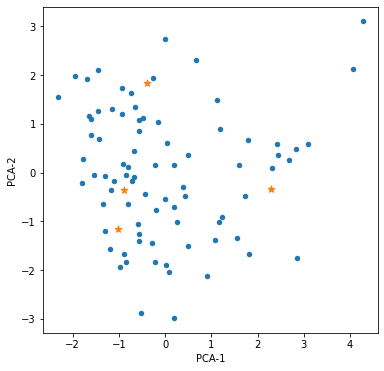

In [26]:
i = np.random.randint(len(df_group))
idx = df_group.index.tolist()[i]
print('Number of sections for %s: %d'%(idx, df_group.loc[idx, 'num_sec']))

plt.figure(figsize=(6, 6))
plt.scatter(
    x = [x[0] for x in para_enc_2dim.loc[idx].tolist()],
    y = [x[1] for x in para_enc_2dim.loc[idx].tolist()],
    s = 20
)
plt.scatter(
    x = [x[0] for x in kmeans_centroids_2dim.loc[idx].tolist()],
    y = [x[1] for x in kmeans_centroids_2dim.loc[idx].tolist()],
    marker='*',
    s = 50
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

##### Calculate Cosine Similarity / Euclidean Distance

In [27]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))

def row_cosine_sim(r):
    idx = r.name[:2]
    centroids = df_group.loc[idx, 'kmeans_centroids']
    return [cosine_sim(r.para_enc, c) for c in centroids]

df['cosine_sim'] = df.progress_apply(lambda row: row_cosine_sim(row), axis=1)

100%|██████████| 18773/18773 [00:09<00:00, 1917.20it/s]


In [28]:
def euclidean_dist(a, b):
    return np.sqrt(np.sum((a-b)**2))

def row_euclidean_dist(r):
    idx = r.name[:2]
    centroids = df_group.loc[idx, 'kmeans_centroids']
    return [euclidean_dist(r.para_enc, c) for c in centroids]

df['euclidean_dist'] = df.progress_apply(lambda row: row_euclidean_dist(row), axis=1)

100%|██████████| 18773/18773 [00:08<00:00, 2277.96it/s]


##### Find Best Paragraph for each Book, Chapter, Centroid

In [29]:
df_best_para = df.reset_index(level=[2, 3]).groupby(['book', 'chapter'], sort=False).agg({
    'section': lambda s: list(s),
    'subsection': lambda ss: list(ss),
    'para': lambda p: list(p),
    'bullets': lambda b: list(b)[0],
    'cosine_sim': lambda c: list(c),
    'euclidean_dist': lambda e: list(e)
})
df_best_para.cosine_sim = df_best_para.cosine_sim.map(lambda c: np.array(c))
df_best_para.euclidean_dist = df_best_para.euclidean_dist.map(lambda e: np.array(e))

In [30]:
df_best_para['best_para_cosine'] = df_best_para.cosine_sim.map(lambda c: np.argmax(c, axis=0))
df_best_para['best_para_euclidean'] = df_best_para.euclidean_dist.map(lambda e: np.argmin(e, axis=0))

##### How Many Sections Are We Covering?

In [31]:
def calculate_diversity(r):
    best_idx = r.best_para_cosine
    all_sections = set(r.section)
    
    selected_sections = set([r.section[i] for i in best_idx])
    
    return len(selected_sections.intersection(all_sections))/len(all_sections)*100
    
df_best_para.apply(lambda row: calculate_diversity(row), axis=1).describe()

count    453.000000
mean      65.742854
std       15.920651
min       20.000000
25%       54.545455
50%       66.666667
75%       75.000000
max      100.000000
dtype: float64

### Cosine Similarity

##### Expanding from Best Paragraph Based on Cosine Sim

In [32]:
df_best_para['para_num_tok'] =\
    df_best_para.para.map(lambda ps: np.array([len(tokenizer.tokenize(p)) for p in ps]))

In [33]:
def expand_based_on_cosine(r):
    max_length = len(r.para)
    max_idx = max_length-1
    
    extracted_para = []
    
    # Calculate the fraction we need to extract
    # based on total number of tokens in this chp
    # and number of centroids (sections) in this chp
    # do not go over the model max length
    num_tok_tot = sum(r.para_num_tok)
    num_tok_th = min(
        int(0.8*num_tok_tot / len(r.best_para_cosine)),
        0.9*tokenizer.model_max_length)
    
    for i, best in enumerate(r.best_para_cosine):
        merged_para_idx = [best]
        num_tok = r.para_num_tok[best]
        
        while num_tok < num_tok_th:
            if len(merged_para_idx) == max_length : break
            elif 0 in merged_para_idx:
                merged_para_idx.append(max(merged_para_idx)+1)
            elif max_idx in merged_para_idx:
                merged_para_idx.append(min(merged_para_idx)-1)
            else:
                if (r.cosine_sim)[min(merged_para_idx)-1, i] <\
                    (r.cosine_sim)[max(merged_para_idx)+1, i]:
                    merged_para_idx.append(max(merged_para_idx)+1)
                else:
                    merged_para_idx.append(min(merged_para_idx)-1)
            num_tok = np.sum(r.para_num_tok[merged_para_idx])
                  
        extracted_para.append(sorted(merged_para_idx))
        
    return extracted_para

df_best_para['selected_para_cosine'] =\
    df_best_para.progress_apply(lambda row: expand_based_on_cosine(row), axis=1)

100%|██████████| 453/453 [00:01<00:00, 355.37it/s]


##### Study Overlap and Remove Useless (>90% overlap) Entries

In [34]:
df_remove_overlap = df_best_para.copy()

In [35]:
def create_overlap_matrix(r):
    num_centr = len(r.selected_para_cosine)
    overlap_matrix = np.zeros((num_centr,num_centr))
    
    def list_overlap(a, b):
        return list( set(a).intersection(set(b)) )
    
    for i in range(num_centr):
        for j in range(num_centr):
            if i == j : continue
            num_tok_i = np.sum(r.para_num_tok[r.selected_para_cosine[i]])
            overlap = list_overlap(
                r.selected_para_cosine[i], r.selected_para_cosine[j])
            num_tok_overlap = np.sum(r.para_num_tok[overlap])
            assert num_tok_overlap <= num_tok_i
            
            overlap_matrix[i, j] = round(num_tok_overlap/num_tok_i*100, 2)
    
    return overlap_matrix

def remove_big_overlap(r, threshold):
    om = r.overlap_matrix
    big_overlap_idx = np.argwhere(om >= threshold)
    to_be_removed = set()
    for idx in big_overlap_idx:
        i, j = idx[0], idx[1]
        if om[i, j] == om[j, i]:
            if i in to_be_removed or j in to_be_removed : continue
            else : to_be_removed.add(i)
        elif om[i, j] > om[j, i]:
            to_be_removed.add(i)
        else:
            to_be_removed.add(j)
    return [s for i, s in enumerate(r.selected_para_cosine) if i not in to_be_removed]

In [36]:
df_remove_overlap['overlap_matrix'] = df_remove_overlap.apply(lambda row: create_overlap_matrix(row), axis=1)
df_remove_overlap.overlap_matrix.map(lambda om: np.sum(om > 90)).describe()

count    453.000000
mean       1.668874
std        1.874568
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        8.000000
Name: overlap_matrix, dtype: float64

In [37]:
df_remove_overlap.selected_para_cosine = df_remove_overlap.apply(lambda row: remove_big_overlap(row, 90), axis=1)

df_remove_overlap['overlap_matrix'] = df_remove_overlap.apply(lambda row: create_overlap_matrix(row), axis=1)
df_remove_overlap.overlap_matrix.map(lambda om: np.sum(om > 90)).describe()

count    453.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: overlap_matrix, dtype: float64

##### Merge when >90% overlap Entries

In [38]:
df_merge_overlap = df_best_para.copy()

In [39]:
def find_big_overlap(r, threshold):
    om = r.overlap_matrix
    big_overlap_idx = np.argwhere(om >= threshold)
    big_overlap_idx = set([frozenset(t) for t in big_overlap_idx])
    merged = set()
    to_be_merged = set()
    for idx in big_overlap_idx:
        idx = tuple(idx)
        i, j = idx[0], idx[1]
        if i not in merged and j not in merged:
            to_be_merged.add(idx)
            merged.add(i)
            merged.add(j)
    return to_be_merged

def merge_para(r):
    for i, j in r.to_be_merged:
        r.selected_para_cosine[i] = np.array(list(set(
            np.concatenate((r.selected_para_cosine[i], r.selected_para_cosine[j])))))
        
        r.selected_para_cosine[j] = None
    r.selected_para_cosine = [sp for sp in r.selected_para_cosine if sp is not None]

In [40]:
while True:
    df_merge_overlap['overlap_matrix'] = df_merge_overlap.apply(create_overlap_matrix, axis=1)

    df_merge_overlap['to_be_merged'] = df_merge_overlap.apply(lambda row: find_big_overlap(row, 90), axis=1)

    num_to_be_merged = df_merge_overlap.to_be_merged.map(len).sum()
    print('Para to be merged: %d'%num_to_be_merged)
    if (num_to_be_merged <= 0) : break

    df_merge_overlap.apply(merge_para, axis=1)

Para to be merged: 370
Para to be merged: 39
Para to be merged: 0


### Finalize Results Remove Overlap

In [41]:
df_remove_overlap_tobesaved = df_remove_overlap.explode('selected_para_cosine')
df_remove_overlap_tobesaved = df_remove_overlap_tobesaved.drop(
    columns=['best_para_cosine', 'best_para_euclidean', 'cosine_sim', 'euclidean_dist', 'overlap_matrix'])

df_remove_overlap_tobesaved['selected_para'] = df_remove_overlap_tobesaved.apply(lambda row:\
    [p for i, p in enumerate(row.para) if i in row.selected_para_cosine], axis=1)

df_remove_overlap_tobesaved['para_num_tok'] = df_remove_overlap_tobesaved.apply(lambda row:\
    [p for i, p in enumerate(row.para_num_tok) if i in row.selected_para_cosine], axis=1)

In [42]:
df_remove_overlap_tobesaved.para_num_tok.map(sum).describe()

count    2235.000000
mean      463.276063
std       206.719927
min        97.000000
25%       315.000000
50%       413.000000
75%       574.000000
max      1210.000000
Name: para_num_tok, dtype: float64

In [43]:
df_remove_overlap_tobesaved.to_csv(OUTPUT_PATH+'df_cosine_remove.csv')

##### Compare to Para Wordembed ST Dataset

In [40]:
def precision(pred, ref):
    return round(100*len(pred.intersection(ref)) / len(pred), 2)
    
def recall(pred, ref):
    return round(100*len(pred.intersection(ref)) / len(ref), 2)

def fmeasure(prec, rec):
    if prec + rec == 0 : return 0
    return round(2*prec*rec/(prec+rec), 2)

flatten = lambda t: [item for sublist in t for item in sublist]

In [60]:
for t in ['base', 'th']:
    df_para_wordembed_st =\
        pd.read_csv(magma_dir+'datasets/karger_books_para_wordembed/'+MODEL+'/st/df_'+t+'_selected_para.csv')\
        .set_index(['book', 'chapter'])
    df_para_wordembed_st.para = df_para_wordembed_st.para.map(eval)
    df_para_wordembed_st.best_match = df_para_wordembed_st.best_match.map(eval)

    num_para = df_para_wordembed_st.para.map(len)

    df_remove_overlap_tobesaved = pd.read_csv(OUTPUT_PATH+'df_cosine_remove.csv').set_index(['book', 'chapter'])
    df_remove_overlap_tobesaved.selected_para_cosine = df_remove_overlap_tobesaved.selected_para_cosine.map(eval)
    df_remove_overlap_tobesaved = df_remove_overlap_tobesaved.groupby(['book', 'chapter'], sort=False).agg({
        'selected_para_cosine': lambda p: list(p)
    })
    df_remove_overlap_tobesaved.selected_para_cosine = df_remove_overlap_tobesaved.selected_para_cosine

    selected_para = df_remove_overlap_tobesaved.selected_para_cosine.map(lambda pp: set(flatten(pp)))
    best_match = df_para_wordembed_st.best_match.map(set)

    df_comparison = pd.concat([num_para, selected_para, best_match], axis=1).rename(
        columns={'para': 'num_para', 'selected_para_cosine': 'unsup_selected', 'best_match': 'sup_selected'})
    df_comparison['unsup_coverage'] = 100*df_comparison.unsup_selected.map(len) / df_comparison.num_para
    df_comparison['sup_coverage'] = 100*df_comparison.sup_selected.map(len) / df_comparison.num_para
    
    df_comparison['intersection'] = 100*df_comparison.apply(lambda r:
        len(r.unsup_selected.intersection(r.sup_selected)) / r.num_para, axis=1)

    df_comparison['precision'] = df_comparison.apply(lambda r:
        precision(r.unsup_selected, r.sup_selected), axis=1)
    df_comparison['recall'] = df_comparison.apply(lambda r:
        recall(r.unsup_selected, r.sup_selected), axis=1)
    
    df_comparison.drop(columns='num_para', inplace=True)
    
    print(t+'\n')
    print(df_comparison.describe())
    print('\n')

base

       unsup_coverage  sup_coverage  intersection   precision      recall
count      453.000000    453.000000    453.000000  453.000000  453.000000
mean        66.222847     29.231305     20.627977   30.734967   69.446291
std         11.215380     15.454056     13.061869   17.927027   21.818957
min         19.285714      2.564103      0.000000    0.000000    0.000000
25%         59.677419     18.000000     11.111111   17.240000   57.140000
50%         66.666667     25.714286     18.181818   27.270000   70.000000
75%         73.076923     38.095238     28.571429   41.670000   85.710000
max         93.333333    100.000000     80.000000  100.000000  100.000000


th

       unsup_coverage  sup_coverage  intersection   precision      recall
count      453.000000    453.000000    453.000000  453.000000  453.000000
mean        66.222847     63.226644     43.387649   65.453422   68.358587
std         11.215380     15.442000     14.890276   19.728711   16.783563
min         19.285714     

### Finalize Results Merge Overlap

In [46]:
df_merge_overlap_tobesaved = df_merge_overlap.explode('selected_para_cosine')
df_merge_overlap_tobesaved = df_merge_overlap_tobesaved.drop(
    columns=['best_para_cosine', 'best_para_euclidean', 'cosine_sim', 'euclidean_dist', 'overlap_matrix'])

df_merge_overlap_tobesaved['selected_para'] = df_merge_overlap_tobesaved.apply(lambda row:\
    [p for i, p in enumerate(row.para) if i in row.selected_para_cosine], axis=1)

df_merge_overlap_tobesaved['para_num_tok'] = df_merge_overlap_tobesaved.apply(lambda row:\
    [p for i, p in enumerate(row.para_num_tok) if i in row.selected_para_cosine], axis=1)

In [47]:
df_merge_overlap_tobesaved.para_num_tok.map(sum).describe()

count    2235.000000
mean      463.687248
std       207.006395
min        97.000000
25%       316.000000
50%       413.000000
75%       576.000000
max      1210.000000
Name: para_num_tok, dtype: float64

In [48]:
df_merge_overlap_tobesaved.to_csv(OUTPUT_PATH+'df_cosine_merge.csv')

##### Compare to Para Wordembed ST Dataset

In [49]:
for t in ['base', 'th']:
    df_para_wordembed_st =\
        pd.read_csv(magma_dir+'datasets/karger_books_para_wordembed/'+MODEL+'/st/df_'+t+'_selected_para.csv')\
        .set_index(['book', 'chapter'])
    df_para_wordembed_st.para = df_para_wordembed_st.para.map(eval)
    df_para_wordembed_st.best_match = df_para_wordembed_st.best_match.map(eval)
    
    selected_para = df_merge_overlap.selected_para_cosine.map(lambda l: set(flatten(l)))
    best_match = df_para_wordembed_st.best_match.map(set)
    df_comparison = pd.concat([selected_para, best_match], axis=1)
    
    df_comparison['precision'] = df_comparison.apply(
        lambda row: precision(row.selected_para_cosine, row.best_match), axis=1)
    df_comparison['recall'] = df_comparison.apply(
        lambda row: recall(row.selected_para_cosine, row.best_match), axis=1)
    df_comparison['fmeasure'] = df_comparison.apply(
        lambda row: fmeasure(row.precision, row.recall), axis=1)
    
    print(t+'\n')
    print(df_comparison.describe())
    print()

base

        precision      recall    fmeasure
count  453.000000  453.000000  453.000000
mean    65.810397   68.573245   65.816623
std     19.499333   16.686714   16.110597
min      3.330000    5.560000    4.170000
25%     53.230000   58.330000   56.140000
50%     66.670000   70.000000   68.420000
75%     80.000000   80.000000   77.550000
max    100.000000  100.000000  100.000000

th

        precision      recall    fmeasure
count  453.000000  453.000000  453.000000
mean    65.374415   68.635011   65.590221
std     19.660060   16.835372   16.298023
min      0.000000    0.000000    0.000000
25%     52.940000   58.330000   56.140000
50%     66.670000   70.000000   68.180000
75%     79.310000   80.000000   76.930000
max    100.000000  100.000000  100.000000



### Euclidean Distance

##### Expanding from Best Paragraph Based on Euclidean Distance

In [ ]:
df_best_para['para_num_tok'] =\
    df_best_para.para.map(lambda ps: np.array([len(tokenizer.tokenize(p)) for p in ps]))

In [ ]:
def expand_based_on_euclidean(r):
    max_length = len(r.para)
    max_idx = max_length-1
    
    extracted_para = []
    
    # Calculate the fraction we need to extract
    # based on total number of tokens in this chp
    # and number of centroids (sections) in this chp
    # do not go over the model max length
    num_tok_tot = sum(r.para_num_tok)
    num_tok_th = min(
        int(0.8*num_tok_tot / len(r.best_para_euclidean)),
        0.9*tokenizer.model_max_length)
    
    for i, best in enumerate(r.best_para_euclidean):
        merged_para_idx = [best]
        num_tok = r.para_num_tok[best]
        
        while num_tok < num_tok_th:
            if len(merged_para_idx) == max_length : break
            elif 0 in merged_para_idx:
                merged_para_idx.append(max(merged_para_idx)+1)
            elif max_idx in merged_para_idx:
                merged_para_idx.append(min(merged_para_idx)-1)
            else:
                if (r.euclidean_dist)[min(merged_para_idx)-1, i] >\
                    (r.euclidean_dist)[max(merged_para_idx)+1, i]:
                    merged_para_idx.append(max(merged_para_idx)+1)
                else:
                    merged_para_idx.append(min(merged_para_idx)-1)
            num_tok = np.sum(r.para_num_tok[merged_para_idx])
                  
        extracted_para.append(sorted(merged_para_idx))
        
    return extracted_para

df_best_para['selected_para_euclidean'] =\
    df_best_para.progress_apply(lambda row: expand_based_on_euclidean(row), axis=1)

##### Study Overlap and Remove Useless (>90% overlap) Entries

In [ ]:
def study_overlap(r):
    num_centr = len(r.selected_para_euclidean)
    overlap_matrix = np.zeros((num_centr,num_centr))
    
    def list_overlap(a, b):
        return list( set(a).intersection(set(b)) )
    
    for i in range(num_centr):
        for j in range(num_centr):
            if i == j : continue
            num_tok_i = np.sum(r.para_num_tok[r.selected_para_euclidean[i]])
            overlap = list_overlap(
                r.selected_para_euclidean[i], r.selected_para_euclidean[j])
            num_tok_overlap = np.sum(r.para_num_tok[overlap])
            assert num_tok_overlap <= num_tok_i
            
            overlap_matrix[i, j] = num_tok_overlap/num_tok_i*100
    
    return overlap_matrix
    
df_best_para['overlap_matrix'] = df_best_para.apply(lambda row: study_overlap(row), axis=1)
df_best_para.overlap_matrix.map(lambda om: np.sum(om > 90)).describe()

In [ ]:
def remove_big_overlap(r, threshold):
    om = r.overlap_matrix
    big_overlap_idx = np.argwhere(om >= threshold)
    to_be_removed = set()
    for idx in big_overlap_idx:
        i, j = idx[0], idx[1]
        if om[i, j] == om[j, i]:
            if i in to_be_removed or j in to_be_removed : continue
            else : to_be_removed.add(i)
        elif om[i, j] > om[j, i]:
            to_be_removed.add(i)
        else:
            to_be_removed.add(j)
    return [s for i, s in enumerate(r.selected_para_euclidean) if i not in to_be_removed]

df_best_para.selected_para_euclidean = df_best_para.apply(lambda row: remove_big_overlap(row, 90), axis=1)

In [ ]:
df_best_para['overlap_matrix'] = df_best_para.apply(lambda row: study_overlap(row), axis=1)
df_best_para.overlap_matrix.map(lambda om: np.sum(om > 90)).describe()

##### Finalize Results

In [ ]:
df_selected_para_euclidean = df_best_para.explode('selected_para_euclidean')
df_selected_para_euclidean = df_selected_para_euclidean.drop(
    columns=['best_para_cosine', 'best_para_euclidean', 'cosine_sim', 'euclidean_dist', 'overlap_matrix'])

df_selected_para_euclidean['selected_para'] = df_selected_para_euclidean.apply(lambda row:\
    [p for i, p in enumerate(row.para) if i in row.selected_para_euclidean], axis=1)

df_selected_para_euclidean['para_num_tok'] = df_selected_para_euclidean.apply(lambda row:\
    [p for i, p in enumerate(row.para_num_tok) if i in row.selected_para_euclidean], axis=1)

In [ ]:
df_selected_para_euclidean.para_num_tok.map(sum).describe()

In [ ]:
df_selected_para_euclidean.to_csv(OUTPUT_PATH+'df_euclidean.csv')

##### Compare to Para Wordembed ST Dataset

In [ ]:
df_para_wordembed_st =\
    pd.read_csv(magma_dir+'datasets/karger_books_para_wordembed/'+MODEL+'/st/df_selected_para.csv')\
    .set_index(['book', 'chapter'])
df_para_wordembed_st.para = df_para_wordembed_st.para.map(eval)
df_para_wordembed_st.best_match = df_para_wordembed_st.best_match.map(eval)

In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

selected_para = df_best_para.selected_para_euclidean.map(lambda l: set(flatten(l)))

best_match = df_para_wordembed_st.best_match.map(set)

df_comparison = pd.concat([selected_para, best_match], axis=1)

In [ ]:
def precision(pred, ref):
    return round(100*len(pred.intersection(ref)) / len(pred), 2)
    
def recall(pred, ref):
    return round(100*len(pred.intersection(ref)) / len(ref), 2)

def fmeasure(prec, rec):
    if prec + rec == 0 : return 0
    return round(2*prec*rec/(prec+rec), 2)

df_comparison['precision'] = df_comparison.apply(
    lambda row: precision(row.selected_para_euclidean, row.best_match), axis=1)
df_comparison['recall'] = df_comparison.apply(
    lambda row: recall(row.selected_para_euclidean, row.best_match), axis=1)
df_comparison['fmeasure'] = df_comparison.apply(
    lambda row: fmeasure(row.precision, row.recall), axis=1)

In [ ]:
df_comparison.describe()